- This notebooks allows to study the link between the 3D shapes of the galaxies and the dark matter halos that host them. One is using here halo catalogs produced thanks to the N-body simulations AbacusSummit, from which one can directly extract the 3D morphology of the halos. Then, one measure the connection between their 3D shape and the one of the galaxies that populate them, that one measures from their observed projected images (see 3D_galaxies => 3D_galaxies.ipynb)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from random import *

from scipy.spatial.transform import Rotation

import torch
from torch.distributions import Uniform

from sbi.utils import BoxUniform
from sbi.analysis import pairplot
from sbi.inference import NPE, SNPE, simulate_for_sbi, infer
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
    prepare_for_sbi
)

import corner
import pandas as pd

from astropy.io import fits


/opt/homebrew/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Downloading the Abacus halos (z=0.725)

One is using halo catalog produced thanks to the AbacusSummit N-body simulations

In [50]:
nb_halos=25_000

halos_table = Table.read('halos_abacus.fits')
halos_table = halos_table[:nb_halos]

### View of the corresponding 3D population of halos

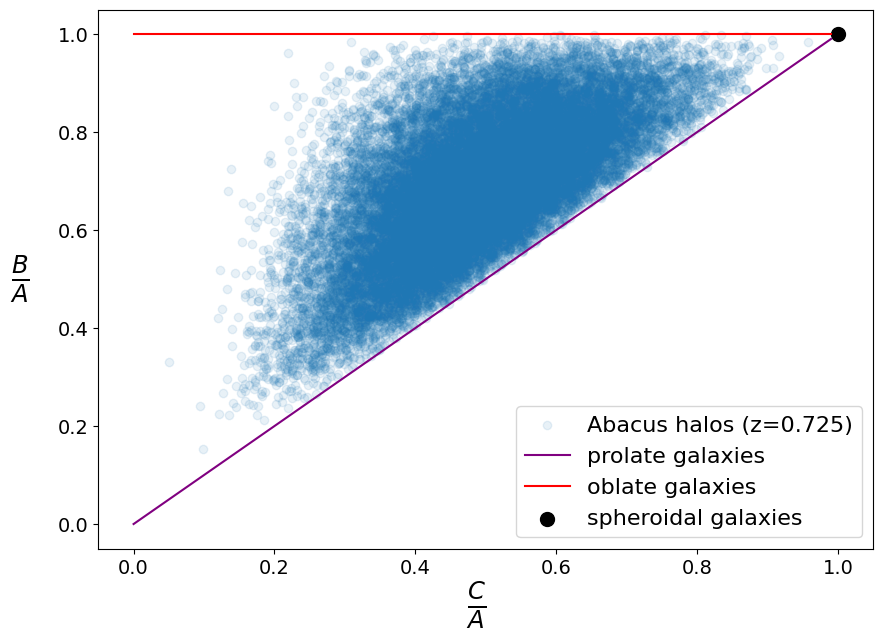

In [52]:
eigenvalues = halos_table['sigman_L2com']

A_h, B_h, C_h = eigenvalues[:,0]**2,eigenvalues[:,1]**2,eigenvalues[:,2]**2


plt.figure( figsize = (10,7) )
plt.scatter(C_h/A_h, B_h/A_h,alpha=0.1,label="Abacus halos (z=0.725)")

plt.xlabel(r"$\frac{C}{A}$", fontsize=25, rotation=0, labelpad=20, ha='right', va='center')
plt.ylabel(r"$\frac{B}{A}$", fontsize=25, rotation=0, labelpad=20, ha='right', va='center')

x=np.linspace(0,0.99,30) ; y=x
plt.plot(x, y,color='purple',label='prolate galaxies')
plt.plot(x, np.ones(len(x)),color='red',label='oblate galaxies')
plt.scatter([1], [1], color='black', label='spheroidal galaxies', s=100)
plt.legend(fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)

In [53]:
# Some functions required for further work

def get_galaxy_orientation_angle(e1,e2):
    return 0.5*np.arctan2(e2,e1)

def e_complex(a,b,r):
    abs_e = (1-(b/a)) / (1+(b/a))
    e1 = abs_e*np.cos(2*r)
    e2 = abs_e*np.sin(2*r)
    return e1, e2

def abs_e(e1,e2):
    return np.sqrt(e1*e1+e2*e2)

def a_b(e1,e2):
    e = abs_e(e1,e2)
    return 1+e,1-e 

In [54]:
# Function used to format ellipsoidal galaxies to match Abacus

def format_ellipsoid(eigenvectors, eigenvalues, position = np.asarray([0,0,0])):

    el = Table()
    el['sigman_eigenvecsMin_L2com'] = eigenvectors[0]
    el['sigman_eigenvecsMid_L2com'] = eigenvectors[1]
    el['sigman_eigenvecsMaj_L2com'] = eigenvectors[2]
    
    el['sigman_L2com'] = np.sqrt(eigenvalues)
    el['sigma_L2com'] = position
    
    return el

### Model : 3D galaxies populating halos (galaxy-halo connection)

- Parameters : $\theta = \{\mu_{\tau_B}, \mu_{\tau_C}, \sigma_{\tau_B}, \sigma_{\tau_C}, r_\tau\}$

In [55]:
def population_3D (tau_B, tau_C, sigma_tau_B, sigma_tau_C, r_tau, el=halos_table, nb_haloes=nb_halos) : 

    halos_table2 = el.copy()
    eigenvalues_orig = np.array(halos_table2['sigman_L2com'])

    valid_eigenvalues = []

    while len(valid_eigenvalues) < nb_haloes:
    
        taus = np.random.multivariate_normal(mean=[tau_B, tau_C], cov=[[sigma_tau_B**2, r_tau * sigma_tau_B * sigma_tau_C],[r_tau * sigma_tau_B * sigma_tau_C, sigma_tau_C**2]],size=nb_haloes)
    
        tau_B2 = np.clip(taus[:, 0], 0, 1)
        tau_C2 = np.clip(taus[:, 1], 0, 1)

        eigenvalues = eigenvalues_orig.copy()
        eigenvalues[:, 1] *= tau_B2
        eigenvalues[:, 2] *= tau_C2

        Ag, Bg, Cg = eigenvalues[:, 0], eigenvalues[:, 1], eigenvalues[:, 2]
        mask = (Bg / Ag <= 1) & (Cg / Ag <= 1) & (Bg >= Cg) & (Bg > 0) & (Cg > 0)
        filtered = eigenvalues[mask]

        to_add = min(nb_haloes - len(valid_eigenvalues), filtered.shape[0])
        valid_eigenvalues.extend(filtered[:to_add])


    eigenvalues = np.array(valid_eigenvalues) 
   
    
    eigenvecs_Min = halos_table2['sigman_eigenvecsMin_L2com'][:len(eigenvalues)]
    eigenvecs_Mid = halos_table2['sigman_eigenvecsMid_L2com'][:len(eigenvalues)]
    eigenvecs_Max = halos_table2['sigman_eigenvecsMaj_L2com'][:len(eigenvalues)]

    eigenvectors = np.stack((eigenvecs_Min, eigenvecs_Mid, eigenvecs_Max), axis=1)

    ellipses = np.array([format_ellipsoid(eigenvectors[i, :, :], eigenvalues[i, :]) for i in range(nb_haloes)])
    ellipses = np.array(ellipses)

    evcl = np.array([ellipses['sigman_eigenvecsMaj_L2com'], ellipses['sigman_eigenvecsMid_L2com'], ellipses['sigman_eigenvecsMin_L2com']])
    evcl=np.transpose(evcl, (1, 0, 2))
    evls = ellipses['sigman_L2com']**2 

    
    return evcl, evls

### Simulator to project 3D galaxies and their host-halos in 2D

In [56]:
# SIMULATOR (for simulation-based inference): projection of the 3D galaxies-halos in 2D along the line of sight ('y')
# Output = summary statistics = P(e)

# References : 
    # (1) Lamman et al., https://arxiv.org/pdf/2209.03949
    # (2) From Gendzwill D. J., Stauffer M. R., 1981, https://www.researchgate.net/profile/D-Gendzwill/publication/225869829_Analysis_of_triaxial_ellipsoids_Their_shapes_plane_sections_and_plane_projections/links/5aa18aa2a6fdcc22e2d11fc5/Analysis-of-triaxial-ellipsoids-Their-shapes-plane-sections-and-plane-projections.pdf


def simulator(theta, 
                el=halos_table,
                nb_haloes=nb_halos, 
                p_axis='y', # The direction of projection (here 'y' denotes by convention the direction of the line-of-sight)
                e_bins=np.linspace(0,1,50) # The number of bins for the histogram of e_counts (output)
               ):

    tau_B, tau_C, sigma_tau_B, sigma_tau_C, r_tau = theta

    evcl, evls = population_3D (tau_B, tau_C, sigma_tau_B, sigma_tau_C, r_tau, el, nb_haloes)
    

    # Projection 3D => 2D
    if p_axis=='x': # Projection perpendicular to the LOS
        K = np.sum(evcl[:,:,0][:,:,None]*(evcl/evls[:,None]), axis=1)
        r = evcl[:,:,2] - evcl[:,:,0] * K[:,2][:,None] / K[:,0][:,None]
        s = evcl[:,:,1] - evcl[:,:,0] * K[:,1][:,None] / K[:,0][:,None] 

    if p_axis=='y': # Projection along the LOS
        K = np.sum(evcl[:,:,1][:,:,None] * (evcl/evls[:,None]), axis=1)
        r = evcl[:,:,0] - evcl[:,:,1] * K[:,0][:,None] / K[:,1][:,None]
        s = evcl[:,:,2] - evcl[:,:,1] * K[:,2][:,None] / K[:,1][:,None]


    # Coefficients A,B,C (eq 23 of (2))
    A1 = np.sum(r**2 / evls, axis=1)
    B1 = np.sum(2*r*s / evls, axis=1)
    C1 = np.sum(s**2 / evls, axis=1)


    # Axis a_p,b_p and orientation angle r_p of the projected galaxy
    r_p = np.pi / 2 + np.arctan2(B1,A1-C1)/2
    a_p = 1/np.sqrt((A1+C1)/2 + (A1-C1)/(2*np.cos(2*r_p)))
    b_p = 1/np.sqrt(A1+C1-(1/a_p**2))


    # Projected ellipticity
    e1, e2 = e_complex(a_p, b_p, r_p) ; e = [e1,e2] ; e=np.array(e)


    # Final output = summary statistics = P(e)
    e_counts,_ = np.histogram(np.sqrt(e[0,:]**2+e[1,:]**2),bins=e_bins)
    

    return e_counts/nb_haloes

### Downloading the data for analysis

- Samples of galaxies considered : ELG, LRG (DESI data) and CMASS galaxies (SDSS data), matched with UNIONS shapes

In [57]:
# CMASS-UNIONS

unions_cmass_table = Table.read('/Users/antonincorinaldi/Documents/stage césure/code/projet_stage/sbi/unions_cmass_cross.fits')

names = [name for name in unions_cmass_table.colnames if len(unions_cmass_table[name].shape) <= 1]
filtered_tbl = unions_cmass_table[names]

unions_cmass_cross = filtered_tbl.to_pandas()
unions_cmass_cross.columns

nb_unions_cmass = len(unions_cmass_cross) ; print(f"Number of CMASS-UNIONS galaxies : {nb_unions_cmass}")

unions_cmass_index = unions_cmass_cross.index



# Ellipticities
e1_values = unions_cmass_cross['e1'][unions_cmass_index]
e2_values = unions_cmass_cross['e2'][unions_cmass_index]

e_cmass = np.vectorize(abs_e)(e1_values, e2_values)



# Histogram of absolute ellipticities P(e)
e_bins=np.linspace(0,1,50)
e_cents = (e_bins[1:]+e_bins[:-1])/2.

e_data_counts_cmass,_ = np.histogram(e_cmass, bins = e_bins) 
e_counts_data = [e_data_counts_cmass]
e_counts_data_cmass=np.array(e_counts_data)
x_obs_cmass = e_counts_data_cmass/nb_unions_cmass

Number of CMASS-UNIONS galaxies : 210440


In [58]:
# ELG-UNIONS

unions_elg_table = Table.read('/Users/antonincorinaldi/Documents/stage césure/code/projet_stage/sbi/unions_elg_cross.fits')

names = [name for name in unions_elg_table.colnames if len(unions_elg_table[name].shape) <= 1]
filtered_tbl = unions_elg_table[names]

unions_elg_cross = filtered_tbl.to_pandas()
unions_elg_cross.columns

nb_unions_elg = len(unions_elg_cross) ; print(f"Number of ELG-UNIONS galaxies : {nb_unions_elg}")

unions_elg_index = unions_elg_cross.index



# Ellipticities
e1_values = unions_elg_cross['e1'][unions_elg_index]
e2_values = unions_elg_cross['e2'][unions_elg_index]

e_elg = np.vectorize(abs_e)(e1_values, e2_values)



# Histogram of absolute ellipticities P(e)
e_bins=np.linspace(0,1,50)
e_cents = (e_bins[1:]+e_bins[:-1])/2.

e_data_counts_elg,_ = np.histogram(e_elg, bins = e_bins) 
e_counts_data = [e_data_counts_elg]
e_counts_data_elg=np.array(e_counts_data)
x_obs_elg = e_counts_data_elg/nb_unions_elg

Number of ELG-UNIONS galaxies : 243544


In [59]:
# LRG-UNIONS

unions_lrg_table = Table.read('unions_desi_lrg_catalogue.fits')

names = [name for name in unions_lrg_table.colnames if len(unions_lrg_table[name].shape) <= 1]
filtered_tbl = unions_lrg_table[names]

unions_lrg = filtered_tbl.to_pandas()
unions_lrg.columns

nb_unions_lrg = len(unions_lrg) ; print(f"Number of LRG-UNIONS : {nb_unions_lrg}")

unions_lrg_index = unions_lrg.index



# Ellipticities
e1_values = unions_lrg['e1'][unions_lrg_index]
e2_values = unions_lrg['e2'][unions_lrg_index]

e_lrg = np.vectorize(abs_e)(e1_values, e2_values)



# Histogram of absolute ellipticities P(e)
e_bins=np.linspace(0,1,50)
e_cents = (e_bins[1:]+e_bins[:-1])/2.

e_data_counts_lrg,_ = np.histogram(e_lrg, bins = e_bins) 
e_counts_data = [e_data_counts_lrg]
e_counts_data_lrg=np.array(e_counts_data)
x_obs_lrg = e_counts_data_lrg/nb_unions_lrg

Number of LRG-UNIONS : 329819


- Loading the posterior obtained after having run the file sbi_posterior_abacus.ipynb (considering the 3D model of galaxies-halos and simulator above) :

In [62]:
class CustomPrior:
    pass

posterior = torch.load('posterior_abacus.pt', weights_only=False) 

### Sampling of the parameters

In [63]:
samples = posterior.sample((1000,), x=x_obs_cmass)
samples_cmass = samples.numpy()

samples = posterior.sample((1000,), x=x_obs_lrg)
samples_lrg = samples.numpy()

samples = posterior.sample((1000,), x=x_obs_elg)
samples_elg = samples.numpy()

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 33332.04it/s]


### Constraints on the parameters of 3D morphological connection between galaxies and halos

/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_80891/363306167.py:111: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


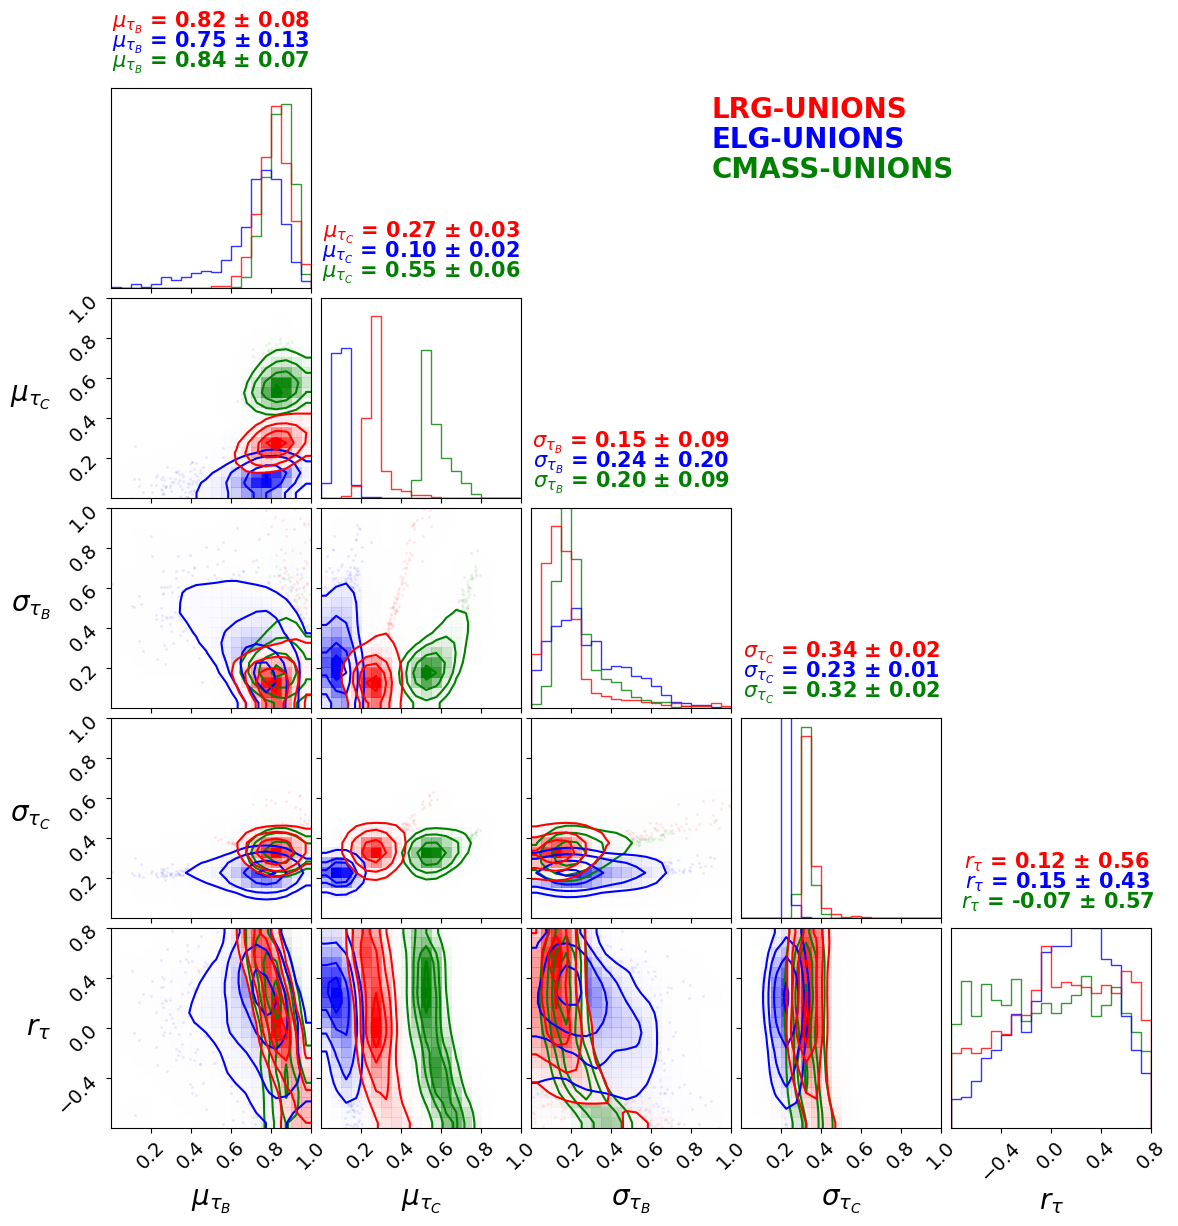

In [64]:
labels = [r"$\mu_{\tau_B}$", r"$\mu_{\tau_C}$", r"$\sigma_{\tau_B}$", r"$\sigma_{\tau_C}$", r"$r_\tau$"]
ranges = [[0, 1], [0, 1], [0, 1], [0, 1], [-0.8, 0.8]]

colors = ["green", "blue", "red"]
dataset_labels = ["CMASS-UNIONS", "ELG-UNIONS", "LRG-UNONS"]
samples_list = [samples_cmass, samples_elg, samples_lrg]

fig = corner.corner(
    samples_cmass, 
    labels=labels, 
    range=ranges, 
    show_titles=False,  
    title_kwargs={"fontsize": 16},
    label_kwargs={"fontsize": 16}, 
    smooth=1.2,  
    plot_density=True,  
    plot_contours=True,  
    color=colors[0], 
    hist_kwargs={"density": True, "alpha": 0.8},
)


corner.corner(
    samples_elg, 
    labels=labels, 
    range=ranges, 
    show_titles=False, 
    title_kwargs={"fontsize": 16},
    label_kwargs={"fontsize": 16}, 
    smooth=1.2,  
    plot_density=True,  
    plot_contours=True,  
    color=colors[1], 
    hist_kwargs={"density": True, "alpha": 0.8},
    fig=plt.gcf() 
)

corner.corner(
    samples_lrg, 
    labels=labels, 
    range=ranges, 
    show_titles=False, 
    title_kwargs={"fontsize": 16},
    label_kwargs={"fontsize": 16}, 
    smooth=1.2, 
    plot_density=True, 
    plot_contours=True,  
    color=colors[2],
    hist_kwargs={"density": True, "alpha": 0.8},
    fig=plt.gcf()  
)



ax = fig.axes[0] 
ax.annotate("CMASS-UNIONS", xy=(3, 0.55), xycoords="axes fraction", color=colors[0], fontsize=20, fontweight="bold")
ax.annotate("ELG-UNIONS", xy=(3, 0.7), xycoords="axes fraction", color=colors[1], fontsize=20, fontweight="bold")
ax.annotate("LRG-UNIONS", xy=(3, 0.85), xycoords="axes fraction", color=colors[2], fontsize=20, fontweight="bold")


axes = np.array(fig.axes).reshape((len(labels), len(labels)))


for i in range(len(labels)):
    ax = axes[i, i]
    y_max = ax.get_ylim()[1]
    y_offset = 0.1 * y_max

    for dataset, color, dataset_name in zip(samples_list, colors, dataset_labels):
        median = np.median(dataset[:, i])
        q16, q84 = np.percentile(dataset[:, i], [16, 84])
        err_minus, err_plus = median - q16, q84 - median

        x_pos = 0.05 
        if labels[i] == r"$\mu_{\tau_B}$":
            x_pos = 0.5  
        elif labels[i] == r"$\mu_{\tau_C}$":
            x_pos = 0.5  
        elif labels[i] == r"$\sigma_{\tau_B}$":
            x_pos = 0.5  
        elif labels[i] == r"$\sigma_{\tau_C}$":
            x_pos = 0.5  
        elif labels[i] == r"$r_\tau$":
            x_pos = 0.05  
        

        ax.text(
            x_pos, y_max + y_offset, 
            f"{labels[i]} = {median:.2f} ± {(err_plus + err_minus) / 2:.2f}",
            color=color, fontsize=15, fontweight="bold",
            ha="center", transform=ax.transData
        )
        y_offset += 0.1 * y_max


for ax in fig.axes:
    ax.tick_params(labelsize=14)


axes = np.array(fig.axes).reshape((len(labels), len(labels)))
for i in range(1, len(labels)): 
    ax = axes[i, 0] 
    label = ax.get_ylabel()
    ax.set_ylabel(label, rotation=0, fontsize=20, ha='right', va='center')

for i in range(len(labels)):
    ax = axes[-1, i] 
    label = ax.get_xlabel()
    ax.set_xlabel(label, fontsize=20)

fig.show()

plt.savefig('3D_constraints_all_Abacus.pdf', bbox_inches='tight')

- $\mu_{\tau_B}/\mu_{\tau_C}$ plane 

/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_80891/3376817569.py:108: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


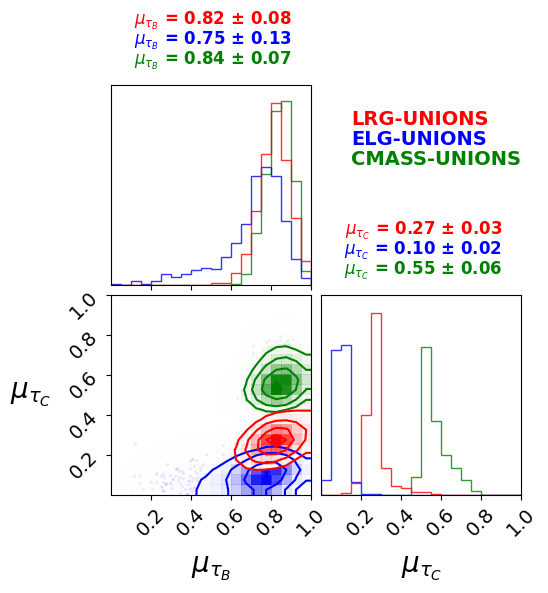

In [65]:
param_indices = [0, 1] 
labels = [r"$\mu_{\tau_B}$", r"$\mu_{\tau_C}$"]
ranges = [[0, 1], [0, 1]]

colors = ["green", "blue", "red"]
dataset_labels = ["CMASS-UNIONS", "ELG-UNIONS", "LRG-UNONS"]
samples_list = [samples_cmass[:, param_indices], 
                samples_elg[:, param_indices], 
                samples_lrg[:, param_indices]]


fig = corner.corner(
    samples_list[0],
    labels=labels,
    range=ranges,
    show_titles=False,
    title_kwargs={"fontsize": 16},
    label_kwargs={"fontsize": 16},
    smooth=1.2,
    plot_density=True,
    plot_contours=True,
    color=colors[0],
    hist_kwargs={"density": True, "alpha": 0.8}
)

corner.corner(
    samples_list[1],
    labels=labels,
    range=ranges,
    show_titles=False,
    title_kwargs={"fontsize": 16},
    label_kwargs={"fontsize": 16},
    smooth=1.2,
    plot_density=True,
    plot_contours=True,
    color=colors[1],
    hist_kwargs={"density": True, "alpha": 0.8},
    fig=plt.gcf()
)

corner.corner(
    samples_list[2],
    labels=labels,
    range=ranges,
    show_titles=False,
    title_kwargs={"fontsize": 16},
    label_kwargs={"fontsize": 16},
    smooth=1.2,
    plot_density=True,
    plot_contours=True,
    color=colors[2],
    hist_kwargs={"density": True, "alpha": 0.8},
    fig=plt.gcf()
)



ax = fig.axes[0] 
ax.annotate("CMASS-UNIONS", xy=(1.2, 0.6), xycoords="axes fraction", color=colors[0], fontsize=14, fontweight="bold")
ax.annotate("ELG-UNIONS", xy=(1.2, 0.7), xycoords="axes fraction", color=colors[1], fontsize=14, fontweight="bold")
ax.annotate("LRG-UNIONS", xy=(1.2, 0.8), xycoords="axes fraction", color=colors[2], fontsize=14, fontweight="bold")


axes = np.array(fig.axes).reshape((len(labels), len(labels)))

for i in range(len(labels)):
    ax = axes[i, i]
    y_max = ax.get_ylim()[1]
    y_offset = 0.1 * y_max

    for dataset, color, dataset_name in zip(samples_list, colors, dataset_labels):
        median = np.median(dataset[:, i])
        q16, q84 = np.percentile(dataset[:, i], [16, 84])
        err_minus, err_plus = median - q16, q84 - median

        if labels[i] == r"$\mu_{\tau_B}$":
            x_pos = 0.51
        elif labels[i] == r"$\mu_{\tau_C}$":
            x_pos = 0.51
        

        ax.text(
            x_pos, y_max + y_offset, 
            f"{labels[i]} = {median:.2f} ± {(err_plus + err_minus) / 2:.2f}",
            color=color, fontsize=12, fontweight="bold",
            ha="center", transform=ax.transData
        )
        y_offset += 0.1 * y_max



for ax in fig.axes:
    ax.tick_params(labelsize=14)


axes = np.array(fig.axes).reshape((len(labels), len(labels)))
mu_C_row = 1  
mu_B_col = 0 

ax_muC = axes[mu_C_row, mu_B_col]
ax_muC.set_ylabel(labels[mu_C_row], fontsize=20, rotation=0, labelpad=25, ha='right', va='center')


for i in range(len(labels)):
    ax = axes[-1, i] 
    ax.set_xlabel(labels[i], fontsize=20)

fig.show()


plt.savefig("mu_tauBmu_tauC.pdf", bbox_inches='tight')

### Saving the best fits...

- ...for the parameters of galaxy-halo connection $\theta$

In [66]:
theta_estimated=np.mean(samples_cmass, axis=0)
tau_B_cmass, tau_C_cmass, sigma_tau_B_cmass, sigma_tau_C_cmass, r_tau_cmass = theta_estimated[0], theta_estimated[1],theta_estimated[2],theta_estimated[3],theta_estimated[4]
print(f"Best fit CMASS-UNIONS {tau_B_cmass, tau_C_cmass, sigma_tau_B_cmass, sigma_tau_C_cmass, r_tau_cmass}")

theta_estimated=np.mean(samples_lrg, axis=0)
tau_B_lrg, tau_C_lrg, sigma_tau_B_lrg, sigma_tau_C_lrg, r_tau_lrg = theta_estimated[0], theta_estimated[1],theta_estimated[2],theta_estimated[3],theta_estimated[4]
print(f"Best fit LRG-UNIONS {tau_B_lrg, tau_C_lrg, sigma_tau_B_lrg, sigma_tau_C_lrg, r_tau_lrg}")

theta_estimated=np.mean(samples_elg, axis=0)
tau_B_elg, tau_C_elg, sigma_tau_B_elg, sigma_tau_C_elg, r_tau_elg = theta_estimated[0], theta_estimated[1],theta_estimated[2],theta_estimated[3],theta_estimated[4]
print(f"Best fit ELG-UNIONS {tau_B_elg, tau_C_elg, sigma_tau_B_elg, sigma_tau_C_elg, r_tau_elg}")

Best fit CMASS-UNIONS (0.83859396, 0.57002634, 0.23223408, 0.32482404, -0.06238568)
Best fit LRG-UNIONS (0.8188227, 0.27217305, 0.18496269, 0.34949782, 0.10407891)
Best fit ELG-UNIONS (0.7120665, 0.09851814, 0.28286585, 0.23086867, 0.07740589)


- ...for the associated $P(\vert e \vert)$

In [20]:
e_counts_simulated_cmass = np.apply_along_axis(simulator, 1, samples_cmass)
hdu = fits.PrimaryHDU(e_counts_simulated_cmass) ; hdul = fits.HDUList([hdu])
hdul.writeto('e_counts_simulated_cmass.fits', overwrite=True)

/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_50070/3344849611.py:10: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  taus = np.random.multivariate_normal(mean=[tau_B, tau_C], cov=[[sigma_tau_B**2, r_tau * sigma_tau_B * sigma_tau_C],[r_tau * sigma_tau_B * sigma_tau_C, sigma_tau_C**2]],size=nb_haloes)
/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_50070/451382173.py:33: RuntimeWarning: invalid value encountered in sqrt
  a_p = 1/np.sqrt((A1+C1)/2 + (A1-C1)/(2*np.cos(2*r_p)))


In [67]:
hdul = fits.open('e_counts_simulated_cmass.fits') 
e_counts_simulated_cmass = hdul[0].data

median_cmass = np.median(e_counts_simulated_cmass, axis=0)
quantiles_cmass = np.quantile(e_counts_simulated_cmass, [0.16,0.84], axis=0)

In [21]:
e_counts_simulated_elg = np.apply_along_axis(simulator, 1, samples_elg)
hdu = fits.PrimaryHDU(e_counts_simulated_elg) ; hdul = fits.HDUList([hdu])
hdul.writeto('e_counts_simulated_elg.fits', overwrite=True)

/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_50070/3344849611.py:10: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  taus = np.random.multivariate_normal(mean=[tau_B, tau_C], cov=[[sigma_tau_B**2, r_tau * sigma_tau_B * sigma_tau_C],[r_tau * sigma_tau_B * sigma_tau_C, sigma_tau_C**2]],size=nb_haloes)
/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_50070/451382173.py:33: RuntimeWarning: invalid value encountered in sqrt
  a_p = 1/np.sqrt((A1+C1)/2 + (A1-C1)/(2*np.cos(2*r_p)))
/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_50070/451382173.py:33: RuntimeWarning: divide by zero encountered in divide
  a_p = 1/np.sqrt((A1+C1)/2 + (A1-C1)/(2*np.cos(2*r_p)))
/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_50070/451382173.py:34: RuntimeWarning: invalid value encountered in sqrt
  b_p = 1/np.sqrt(A1+C1-(1/a_p**2))


In [68]:
hdul = fits.open('e_counts_simulated_elg.fits') 
e_counts_simulated_elg = hdul[0].data

median_elg = np.median(e_counts_simulated_elg, axis=0)
quantiles_elg = np.quantile(e_counts_simulated_elg, [0.16,0.84], axis=0)

In [22]:
e_counts_simulated_lrg = np.apply_along_axis(simulator, 1, samples_lrg)
hdu = fits.PrimaryHDU(e_counts_simulated_lrg) ; hdul = fits.HDUList([hdu])
hdul.writeto('e_counts_simulated_lrg.fits', overwrite=True)

/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_50070/3344849611.py:10: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  taus = np.random.multivariate_normal(mean=[tau_B, tau_C], cov=[[sigma_tau_B**2, r_tau * sigma_tau_B * sigma_tau_C],[r_tau * sigma_tau_B * sigma_tau_C, sigma_tau_C**2]],size=nb_haloes)
/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_50070/451382173.py:33: RuntimeWarning: invalid value encountered in sqrt
  a_p = 1/np.sqrt((A1+C1)/2 + (A1-C1)/(2*np.cos(2*r_p)))
/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_50070/451382173.py:34: RuntimeWarning: invalid value encountered in sqrt
  b_p = 1/np.sqrt(A1+C1-(1/a_p**2))


In [69]:
hdul = fits.open('e_counts_simulated_lrg.fits') 
e_counts_simulated_lrg = hdul[0].data
median_lrg = np.median(e_counts_simulated_lrg, axis=0)
quantiles_lrg = np.quantile(e_counts_simulated_lrg, [0.16,0.84], axis=0)

### Plotting the P(e) of the halos and the best fit and data for the P(e) of the galaxies populating them

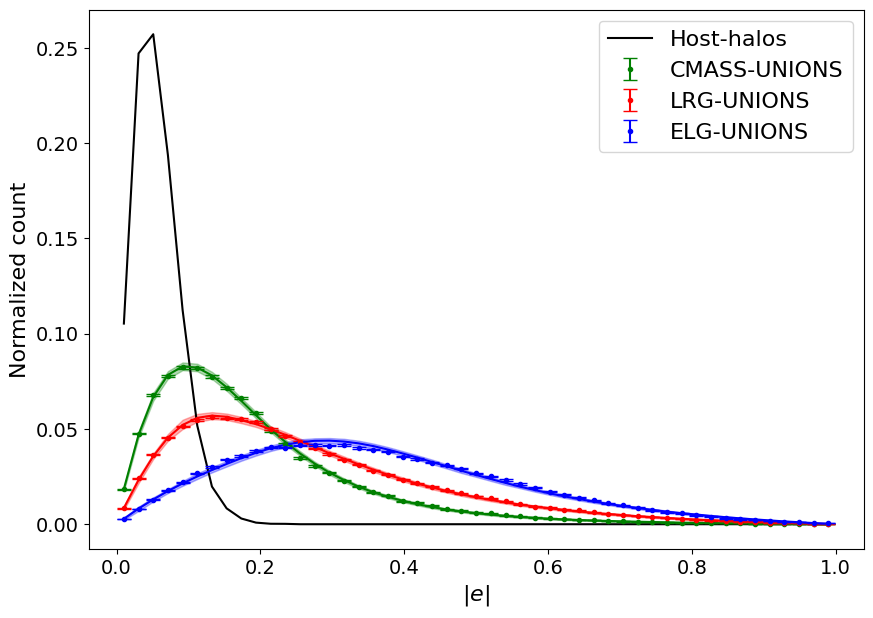

In [70]:
e_bins=np.linspace(0,1,50)
e_cents = (e_bins[1:]+e_bins[:-1])/2.


plt.figure(figsize = (10,7) )

e_h = simulator([1,1,0,0,0], el=haloes_table)


plt.plot(e_cents,e_h, label=r"Host-halos", color='black')

plt.plot(e_cents,median_cmass, linestyle='-',color='green')
plt.errorbar(e_cents, e_data_counts_cmass/nb_unions_cmass, yerr=np.sqrt(e_data_counts_cmass) / nb_unions_cmass, fmt='o',markersize=3, capsize=5, label='CMASS-UNIONS', color='green')
plt.fill_between(e_cents, quantiles_cmass[0,:], quantiles_cmass[1,:], color='green', alpha=0.3)

plt.plot(e_cents,median_lrg, linestyle='-',color='red')
plt.errorbar(e_cents, e_data_counts_lrg/nb_unions_lrg, yerr=np.sqrt(e_data_counts_lrg) / nb_unions_lrg, fmt='o',markersize=3, capsize=5, label='LRG-UNIONS', color='red')
plt.fill_between(e_cents, quantiles_lrg[0,:], quantiles_lrg[1,:], color='red', alpha=0.3)

plt.plot(e_cents,median_elg, linestyle='-',color='blue')
plt.errorbar(e_cents, e_data_counts_elg/nb_unions_elg, yerr=np.sqrt(e_data_counts_elg) / nb_unions_elg, fmt='o',markersize=3, capsize=5, label='ELG-UNIONS', color='blue')
plt.fill_between(e_cents, quantiles_elg[0,:], quantiles_elg[1,:], color='blue', alpha=0.3)



plt.legend(fontsize=16)
plt.xlabel(r"$\vert e \vert$", fontsize=16)
plt.ylabel("Normalized count", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)


plt.savefig("P(e)_all_abacus.pdf", bbox_inches='tight')

Comment : one refines that the halos are rounder than galaxies

### 3D population of galaxies constrained (from the 2D observed populations) inside their host-halos

- Convention : A>B>C

In [71]:
cmass = haloes_table.copy()

cmass2 = np.array(cmass['sigman_L2com']**2)

taus = np.random.multivariate_normal(mean=[tau_B_cmass, tau_C_cmass], 
                                     cov=[[sigma_tau_B_cmass**2, r_tau_cmass * sigma_tau_B_cmass * sigma_tau_C_cmass],[r_tau_cmass * sigma_tau_B_cmass * sigma_tau_C_cmass, sigma_tau_C_cmass**2]],
                                     size=nb_haloes)
    
tau_B2 = np.clip(taus[:, 0], 0, 1)
tau_C2 = np.clip(taus[:, 1], 0, 1)

cmass2[:,1] = cmass2[:,1]*tau_B2 ; cmass2[:,2] = cmass2[:,2]*tau_C2

cmass['sigman_L2com'] = cmass2






lrg = haloes_table.copy()

lrg2 = np.array(lrg['sigman_L2com']**2)

taus = np.random.multivariate_normal(mean=[tau_B_lrg, tau_C_lrg], 
                                     cov=[[sigma_tau_B_lrg**2, r_tau_lrg * sigma_tau_B_lrg * sigma_tau_C_lrg],[r_tau_lrg * sigma_tau_B_lrg * sigma_tau_C_lrg, sigma_tau_C_lrg**2]],
                                     size=nb_haloes)
    
tau_B2 = np.clip(taus[:, 0], 0, 1)
tau_C2 = np.clip(taus[:, 1], 0, 1)

lrg2[:,1] = lrg2[:,1]*tau_B2 ; lrg2[:,2] = lrg2[:,2]*tau_C2

lrg['sigman_L2com'] = lrg2





elg = haloes_table.copy()

elg2 = np.array(lrg['sigman_L2com']**2)

taus = np.random.multivariate_normal(mean=[tau_B_elg, tau_C_elg], 
                                     cov=[[sigma_tau_B_elg**2, r_tau_elg * sigma_tau_B_elg * sigma_tau_C_elg],[r_tau_elg * sigma_tau_B_elg * sigma_tau_C_elg, sigma_tau_C_elg**2]],
                                     size=nb_haloes)
    
tau_B2 = np.clip(taus[:, 0], 0, 1)
tau_C2 = np.clip(taus[:, 1], 0, 1)

elg2[:,1] = elg2[:,1]*tau_B2 ; elg2[:,2] = elg2[:,2]*tau_C2

elg['sigman_L2com'] = elg2

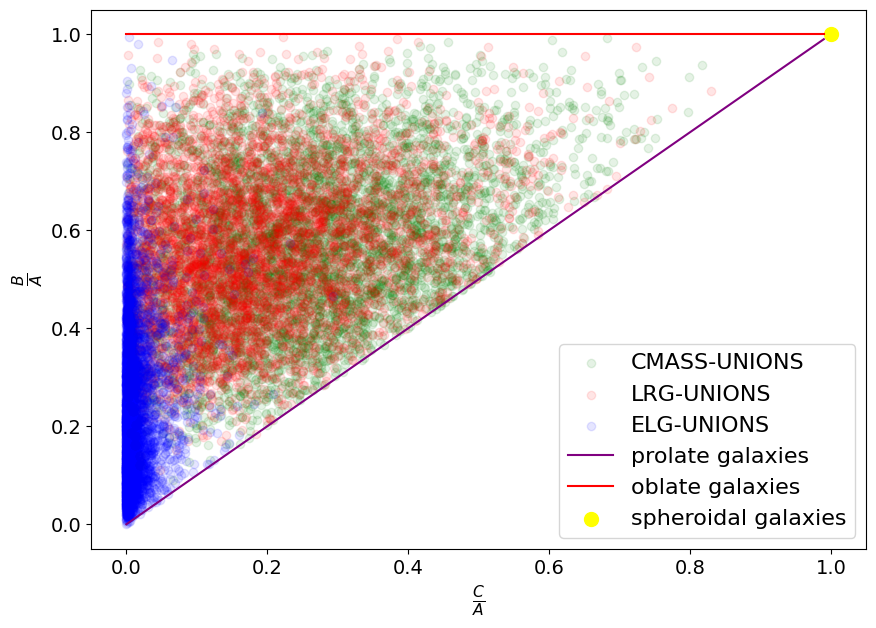

In [72]:
Ag, Bg, Cg = cmass2[:,0], cmass2[:,1], cmass2[:,2]
mask = (Bg / Ag <= 1) & (Cg / Ag <= 1) & (Bg >= Cg) & (Bg > 0) & (Cg > 0)
ABC = cmass2[mask]
A_cmass, B_cmass, C_cmass = ABC[:5000,0], ABC[:5000,1], ABC[:5000,2]


Ag, Bg, Cg = lrg2[:,0], lrg2[:,1], lrg2[:,2]
mask = (Bg / Ag <= 1) & (Cg / Ag <= 1) & (Bg >= Cg) & (Bg > 0) & (Cg > 0)
ABC = lrg2[mask]
A_lrg, B_lrg, C_lrg = ABC[:5000,0], ABC[:5000,1], ABC[:5000,2]


Ag, Bg, Cg = elg2[:,0], elg2[:,1], elg2[:,2]
mask = (Bg / Ag <= 1) & (Cg / Ag <= 1) & (Bg >= Cg) & (Bg > 0) & (Cg > 0)
ABC = elg2[mask]
A_elg, B_elg, C_elg = ABC[:5000,0], ABC[:5000,1], ABC[:5000,2]


haloes=np.array(haloes_table['sigman_L2com'])
Ah, Bh, Ch = haloes[:5000,0]**2, haloes[:5000,1]**2, haloes[:5000,2]**2



plt.figure( figsize = (10,7) )

plt.scatter(C_cmass/A_cmass, B_cmass/A_cmass, alpha=0.1,label=r'CMASS-UNIONS',color='green')
plt.scatter(C_lrg/A_lrg, B_lrg/A_lrg, alpha=0.1,label=r'LRG-UNIONS',color='red')
plt.scatter(C_elg/A_elg, B_elg/A_elg, alpha=0.1,label=r'ELG-UNIONS',color='blue')

plt.xlabel(r"$\frac{C}{A}$",fontsize=16) ; plt.ylabel(r"$\frac{B}{A}$",fontsize=16)


x=np.linspace(0,0.99,30) ; y=x
plt.plot(x, y,color='purple',label='prolate galaxies')
plt.plot(x, np.ones(len(x)),color='red',label='oblate galaxies')
plt.scatter([1], [1], color='yellow', label='spheroidal galaxies', s=100)
plt.legend(fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)